# Targeted poisoning attack on MNIST dataset

## Import Libraries

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

import collections
from tqdm import tqdm
import random
import copy

## Parameters declaration

In [2]:
n_clients = 60
n_test_clients = 60

n_train_dataset_epochs = 6
n_test_dataset_epochs = 3
n_train_epochs = 30
batch_size_train = 20
batch_size_test = 4

client_learning_rate = 0.02
server_learning_rate = 1.5


hidden_units = 256
dropout = 0.1

mal_users_percentage = 0.2
# todo: could also be a list of values
target_value = 3
poisoned_value = 8



## Dataset Loading and manipulation

In [ ]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [ ]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[45])

test_dataset = emnist_test.create_tf_dataset_for_client(
    emnist_train.client_ids[45])

print(emnist_train.client_ids[0:10])
print(emnist_test.client_ids[0:10])
cnt_train = 0
cnt_test = 0

for item in example_dataset:
    cnt_train += 1 

for item in test_dataset:
    cnt_test += 1


print(cnt_train)
print(cnt_test)

### Preprocessing and organizing dataset

In [3]:
shuffle_buffer = 100
# todo change??
prefetch_buffer = 10

In [4]:
def batch_format(element):
    # flatten the images
    return collections.OrderedDict(
        x = tf.reshape(element['pixels'], [-1, 28, 28]),
        y = tf.reshape(element['label'], [-1, 1]))

def preprocess(dataset, train):
    if train == True:
        dataset = dataset.repeat(n_train_dataset_epochs)
    else:
        dataset = dataset.repeat(n_test_dataset_epochs)
        
    dataset = dataset.shuffle(shuffle_buffer, seed = 1)
    if train == True:
        dataset = dataset.batch(batch_size_train)
    else: 
        dataset = dataset.batch(batch_size_test)
        
    dataset = dataset.map(batch_format)
    dataset = dataset.prefetch(prefetch_buffer)

    return dataset

In [5]:
def poison_dataset(dataset, target_honest, target_mal):
    # parse the dataset
    for batch in dataset:
        # get the labels of each batch and convert to numpy array
        labels = batch['y'].numpy()
        # itterate through each label
        for i,y in enumerate(labels):
            # if we find the target label	
            if y == target_honest:
                labels[i] = target_mal
        batch['y'] = tf.convert_to_tensor(labels, dtype = tf.float32)
        # print(batch['y'])
    # return the malicious dataset
    return dataset

In [ ]:
## testing the preprocessing function

example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])
     
preprocessed_example_dataset = preprocess(example_dataset, True)

In [14]:
def make_federated_data(client_data, client_ids, train, mal_users_percentage=0):
    target_honest = 3
    target_mal = 8
    fed_data = []
    for id in client_ids:
        preprocessed_dataset = preprocess(client_data.create_tf_dataset_for_client(id), train)
        prob = random.random()
        # mal% of the users are malicious
        if prob < mal_users_percentage:  
            preprocessed_dataset = poison_dataset(preprocessed_dataset, target_honest, target_mal)              

        fed_data.append(preprocessed_dataset)

    return fed_data

In [ ]:
# print(emnist_test.client_ids[0])
data = make_federated_data(emnist_test, [emnist_train.client_ids[0]], train=False, mal_users_percentage=1)

## Model creation

In [7]:
def create_model():
      return tf.keras.models.Sequential([
      tf.keras.layers.Reshape(input_shape=(28,28,1), target_shape=(28,28,1)),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(dropout),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

In [8]:
def mnist_model():
    keras_model = create_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec = preprocessed_example_dataset.element_spec,
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])     

## Training

In [ ]:
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    mnist_model,
    client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = client_learning_rate),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate = server_learning_rate))

In [ ]:
train_state = training_process.initialize()

In [ ]:
# build the process to have the model's architecture
evaluation_process = tff.learning.algorithms.build_fed_eval(mnist_model)

# initialize the state of the evaluation
evaluation_state = evaluation_process.initialize()
sample_test_clients = emnist_test.client_ids[0:n_test_clients]


# step = 16
# sample_test_clients = [emnist_train.client_ids[x] for x in range (0, n_clients * step, step)]

# test the model with the test data
# question: selection of clients during training??
federated_test_data = make_federated_data(emnist_test, sample_test_clients, train=False)

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

training_loss = []
training_acc = []
eval_loss = []
eval_acc = []

clients = emnist_train.client_ids[0:n_clients]
step = 16
clients = [emnist_train.client_ids[x] for x in range (0, n_clients * step, step)]

#note: slow to converge with random clients, makes sense

for epoch in range(1, n_train_epochs):

    print('Epoch: {:2d}'.format(epoch))
    # client selection, random, chosen from the first 100 clients
    clients = random.sample(emnist_train.client_ids, n_clients)

    federated_train_data = make_federated_data(emnist_train, clients, train=True)
    federated_test_data = make_federated_data(emnist_test, sample_test_clients, train=False)
    
    
    # run a next on the training process to train the model
    result = training_process.next(train_state, federated_train_data)
    # update the model's state and get access to the metrics
    train_state = result.state
    train_metrics = result.metrics
    # print the training metrics
    training_acc.append(train_metrics['client_work']['train']['sparse_categorical_accuracy'])
    training_loss.append(train_metrics['client_work']['train']['loss'])

    print('Training accuracy: {:.3f}, Training loss: {:.3f}'.format(training_acc[-1], training_loss[-1]))

    # evaluate the model with test data

    # get weights from the trainged model
    model_weights = training_process.get_model_weights(train_state)
    # update the evaluation state with them
    evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)
    # run a next() to evaluate the model
    evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)

    # get access to the evaluation metrics
    eval_metrics = evaluation_output.metrics['client_work']['eval']['total_rounds_metrics']

    eval_acc.append(eval_metrics['sparse_categorical_accuracy'])
    eval_loss.append(eval_metrics['loss'])
    # print the training metrics
    print('Testing accuracy: {:.3f}, Testing loss: {:.3f}\n\n'.format(eval_acc[-1], eval_loss[-1]))

In [ ]:
y_true = []
y_pred = []

for batch in evaluation_output:
    print(batch)
    # pred = np.argmax(batch)

#     print(batch['y'])




In [ ]:
emnist_train
# clients = emnist_train.client_ids[0:n_clients]
# print(clients)

In [ ]:
print(evaluation_output.metrics)

In [ ]:
epochs = [x for x in range(1, n_train_epochs)]
plt.plot(epochs, training_acc)
plt.plot(epochs, eval_acc)
plt.show()

In [ ]:
epochs = [x for x in range(1, n_train_epochs)]
plt.plot(epochs, training_loss)
plt.plot(epochs, eval_loss)
plt.show()

In [16]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

accs = []
losses = []

example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

preprocessed_example_dataset = preprocess(example_dataset, True)
 
     
# build the process to have the model's architecture
evaluation_process = tff.learning.algorithms.build_fed_eval(mnist_model)

# initialize the state of the evaluation
sample_test_clients = emnist_test.client_ids[0:n_test_clients]

federated_test_data = make_federated_data(emnist_test, sample_test_clients, train=False)


n_train_epochs = 20

for i in [0, 5, 6, 7]:
    evaluation_state = evaluation_process.initialize()

    eval_acc = []
    eval_loss = []
    
    mal_users_percentage = i / 10
    
    emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

    training_process = tff.learning.algorithms.build_unweighted_fed_avg(
        mnist_model,
        client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = client_learning_rate),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate = server_learning_rate))

    train_state = training_process.initialize()
    print("Model with " + str(i / 10) + "% mal clients")
    for epoch in tqdm(range(n_train_epochs), position = 0, leave = True):
        
        # client selection, random, chosen from the first 100 clients
        # clients = random.sample(emnist_train.client_ids, n_clients)
        clients = emnist_train.client_ids[0:n_clients]

        federated_train_data = make_federated_data(emnist_train, clients, train=True, mal_users_percentage=mal_users_percentage)      
        
        # run a next on the training process to train the model
        result = training_process.next(train_state, federated_train_data)
        # update the model's state and get access to the metrics
        train_state = result.state
                
        # get weights from the trainged model
        model_weights = training_process.get_model_weights(train_state)
        # update the evaluation state with them
        evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)
        # run a next() to evaluate the model
        evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)

        # get access to the evaluation metrics
        eval_metrics = evaluation_output.metrics['client_work']['eval']['total_rounds_metrics']

        eval_acc.append(eval_metrics['sparse_categorical_accuracy'])
        eval_loss.append(eval_metrics['loss'])        

    accs.append(eval_acc)
    losses.append(eval_loss)


Model with 0% mal clients


100%|██████████| 20/20 [01:26<00:00,  4.31s/it]


Model with 5% mal clients


100%|██████████| 20/20 [01:43<00:00,  5.20s/it]


Model with 6% mal clients


100%|██████████| 20/20 [01:47<00:00,  5.38s/it]


Model with 7% mal clients


100%|██████████| 20/20 [01:51<00:00,  5.58s/it]


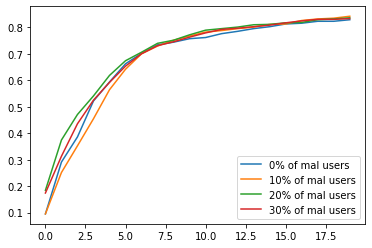

In [17]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_acc in enumerate(accs):

    plt.plot(epochs, model_acc, label=str(cnt * 10) + "% of mal users")

plt.legend()
plt.show()

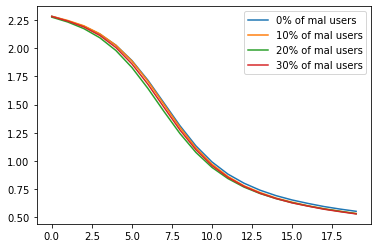

In [20]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_loss in enumerate(losses):

    plt.plot(epochs, model_loss, label=str(cnt * 10) + "% of mal users")

plt.legend()
plt.show()

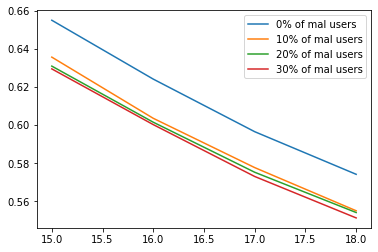

In [21]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_loss in enumerate(losses):

    plt.plot(epochs[15:19], model_loss[15:19], label=str(cnt * 10) + "% of mal users")

plt.legend()
plt.show()